#  Разведочный анализ данных финансовых транзакций

## Описание работы:

Проведён разведочный анализ данных с целью выдвижения продуктовых и технических гипотез — какая ценность может быть извлечена из транзакционной информации для организации, предоставившей данные.
 <br>

&nbsp;&nbsp;&nbsp;&nbsp;

**Предположения о типе компании-владельца данных:**
Данные могли быть собраны и предоставлены:
1. банком, осуществляющим мультивалютные операции;
2. платежной системой,
3. процессинговым центром,
4. финтех-компанией.
<br>

&nbsp;&nbsp;&nbsp;&nbsp;

**Цели EDA, релевантные потребностям таких организаций:**
1. выявление закономерностей, сопровождающих мошеннические транзакции;
2. формулировка продуктовых и технических рекомендаций:
- какие транзакции следует блокировать немедленно;
- какие — маркировать для логирования и последующей проверки;
- какие — сигнализировать в режиме реального времени (пользователю, банку, службе безопасности и др.).

&nbsp;&nbsp;&nbsp;&nbsp;

**В рамках анализа будет проведено:**
- визуализация признаков и распределений;
- проверка, чистка и приведение данных к рабочему формату;
- анализ распределений ключевых признаков;
- поиск закономерностей и корреляций;
- формирование гипотез;
- разработка практических рекомендаций для антимошеннических систем.
<br>

# 1. Описание данных

In [1]:
# Загрузка датафрейма

import pandas as pd

df = pd.read_parquet('transaction_fraud_data.parquet')
df_currency = pd.read_parquet('historical_currency_exchange.parquet')

df.head(5)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [2]:
df_currency.head(5)

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


In [3]:
# Описание датасета

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [ ]:
# Распаковка вложенной структуры последней часовой активности
df_lha = df['last_hour_activity'].apply(pd.Series)
df = pd.concat([df, df_lha.add_prefix('lha_')], axis=1)

df.head(5)

In [ ]:
parquet_path = 'processed_transaction_data.parquet'

df.to_parquet(parquet_path)

In [2]:
import pandas as pd

df = pd.read_parquet('processed_transaction_data.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 28 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [ ]:
# Анализ уникальных значений среди категориальных данных

# Список всех колонок с типом object
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"--- {col} ---")
    print(df[col].value_counts(dropna=False).head(10))  
    print(f"Уникальных значений: {df[col].nunique()}")
    print()

--- transaction_id ---
transaction_id
TX_706baadf    3
TX_18d56778    3
TX_891636c5    3
TX_9c2d174f    3
TX_f4ea6740    3
TX_eef2ac1b    3
TX_4e6f041a    3
TX_65351cc2    2
TX_80498a3e    2
TX_b28c6b9a    2
Name: count, dtype: int64
Уникальных значений: 7477306

--- customer_id ---
customer_id
CUST_91730    4015
CUST_24836    3767
CUST_87928    3756
CUST_81009    3744
CUST_77434    3728
CUST_12255    3699
CUST_49715    3667
CUST_88176    3664
CUST_79625    3655
CUST_41245    3623
Name: count, dtype: int64
Уникальных значений: 4869

--- vendor_category ---
vendor_category
Healthcare       936770
Restaurant       936178
Entertainment    936173
Retail           935883
Travel           935790
Gas              935401
Grocery          934029
Education        933542
Name: count, dtype: int64
Уникальных значений: 8

--- vendor_type ---
vendor_type
online       1401650
physical      935039
medical       468393
pharmacy      468377
local         467902
major         467499
supplies      466765


**Предварительный анализ описательных статистик данных:**

1. Признаки-идентификаторы (неинформативные):
   
   transaction_id, customer_id, device_fingerprint, ip_address -
   очень много уникальных значений (почти уникальны для каждой строки), их нельзя использовать для обобщающих выводов или гипотез. Эти поля нужны только как ключи.

3. Признаки с низким количеством категорий (информативны):
   
   vendor_category (8 категорий), vendor_type (17 категорий), currency (11 категорий), country (12 категорий), city_size (2 категории), card_type (5 категорий), device (9 категорий), channel (3 категории).

   Эти признаки подойдут для анализа доли фрода по категориям и поиска аномальных паттернов.

6. Признаки с большим количеством уникальных значений, но полезные:

   vendor (105 уникальных значений) — может быть полезен для анализа конкретных продавцов, если среди них есть аномалии.

   city — 93% значений = "Unknown City", признак малоинформативен.

8. Признаки с сильным дисбалансом:

   city — почти все транзакции из Unknown City

   city_size —  97% городов = medium

10. Числовые признаки:
    
    amount (сумма транзакции)

    признаки активности lha_*


In [3]:
# В связи с ограниченными объемами вычислительной мощности, возьмем часть выборки для анализа

df_sample = df.sample(frac=0.05, random_state=42)
print(f"Размер выборки: {len(df_sample)} строк")

Размер выборки: 374188 строк


In [6]:
# Определим по средней доле фроде насколько выборка репрезентативна по сравнению с полным датасетом

print(data['is_fraud'].mean())  # сэмпл
print(df['is_fraud'].mean())    # весь датасет

0.1995253722727613
0.19972818498066347


<Axes: title={'center': 'Баланс классов (is_fraud)'}, xlabel='is_fraud'>

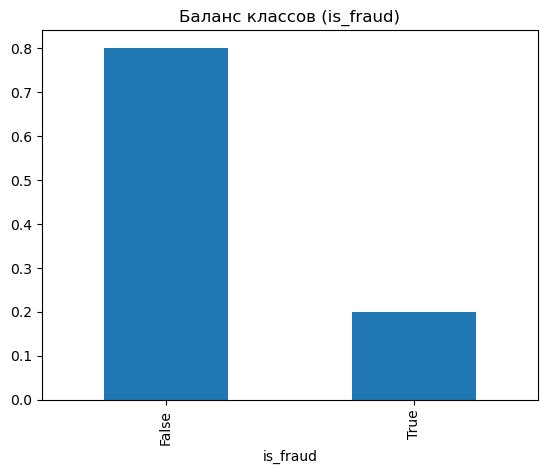

In [5]:
data = df_sample

# Построим распределение классов мошеннических и нормальных операций
data['is_fraud'].value_counts(normalize=True).plot(kind='bar', title="Баланс классов (is_fraud)")

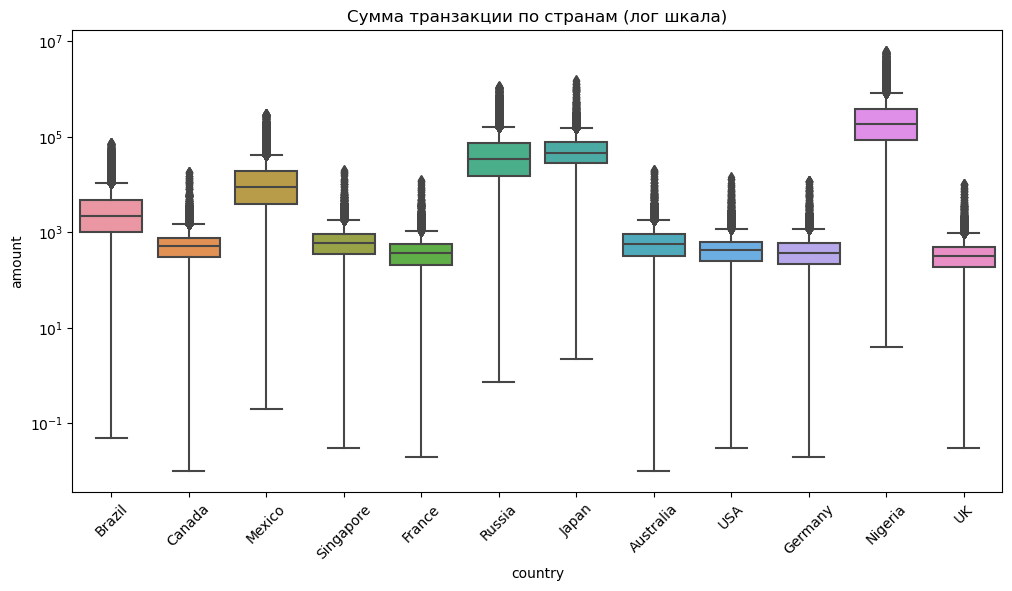

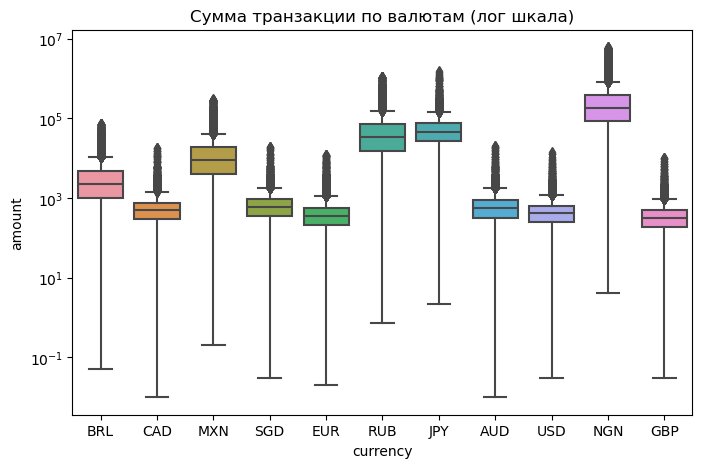

In [7]:
# Построение суммы транзакций по странам для уточнения факта неусловных единиц валют транзакций (суммы приведены в валюте страны)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Boxplot по странам
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='country', y='amount')
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Сумма транзакции по странам (лог шкала)")
plt.show()

# 2. Boxplot по валютам
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='currency', y='amount')
plt.yscale('log')
plt.title("Сумма транзакции по валютам (лог шкала)")
plt.show()

Text(0.5, 1.0, 'Сумма транзакции (amount) в разрезе мошенничества')

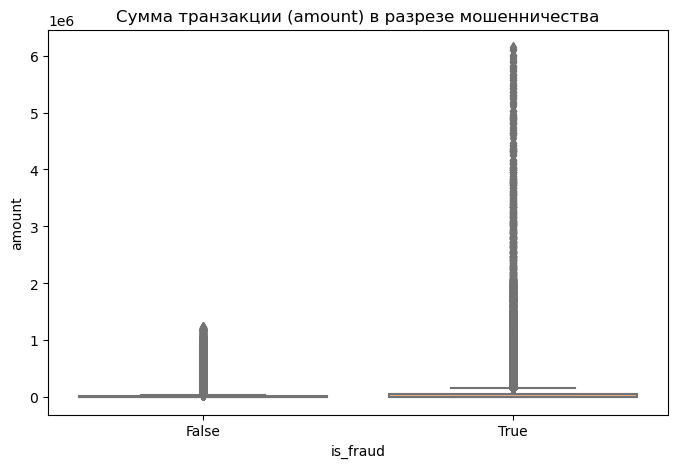

In [8]:
# Построение графика распределения сумм для мошеннических и нормальных операций

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='is_fraud', y='amount', palette='pastel')
plt.title('Сумма транзакции (amount) в разрезе мошенничества')

C:\Users\oljago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


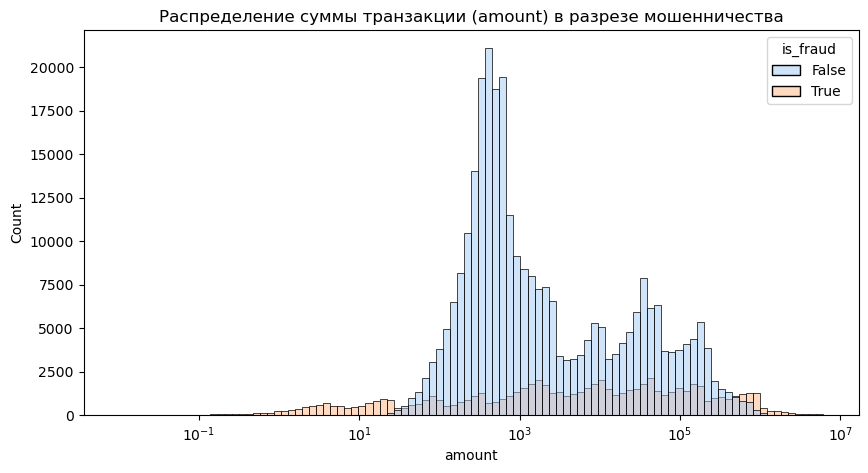

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(data=data, x='amount', hue='is_fraud', bins=100, log_scale=True, palette='pastel')
plt.title('Распределение суммы транзакции (amount) в разрезе мошенничества')
plt.show()

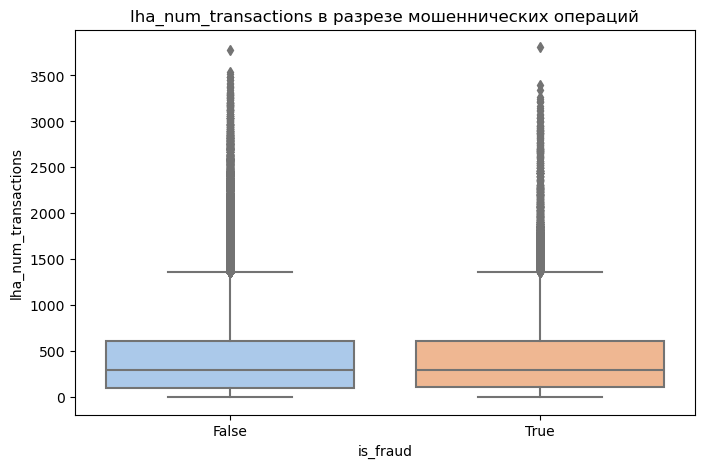

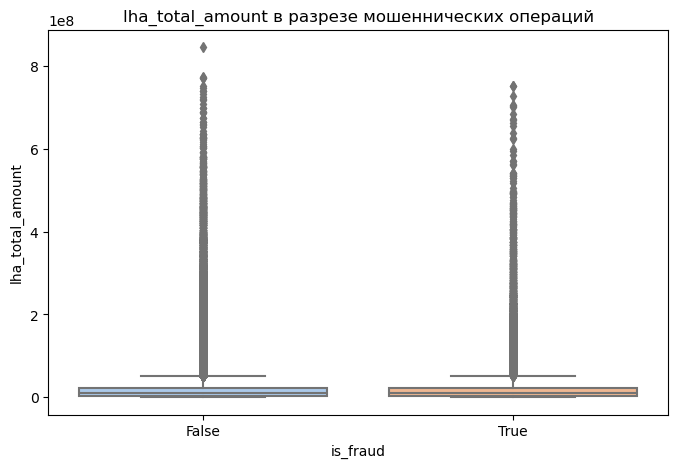

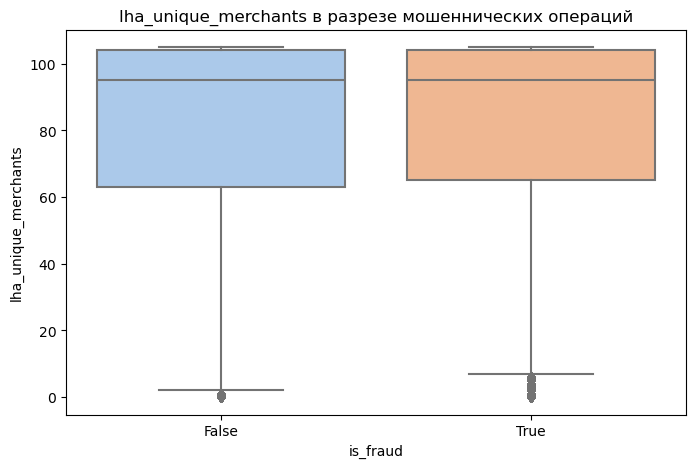

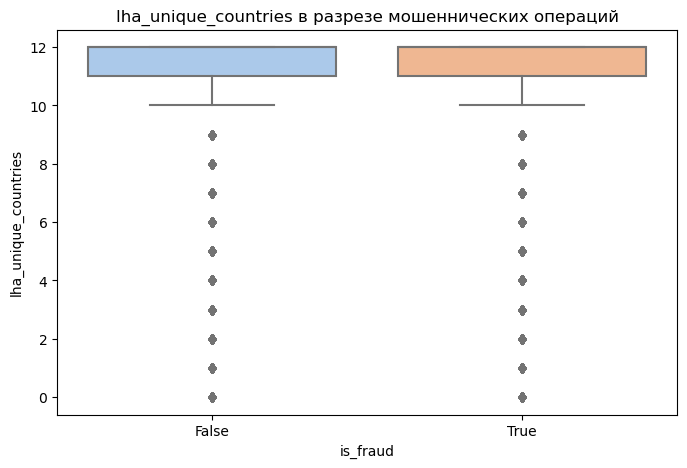

In [10]:
cols = ['lha_num_transactions', 'lha_total_amount', 'lha_unique_merchants', 'lha_unique_countries']
for col in cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=data, x='is_fraud', y=col, palette='pastel')
    plt.title(f'{col} в разрезе мошеннических операций')

Text(0.5, 1.0, 'Категории вендоров и мошеннические операции')

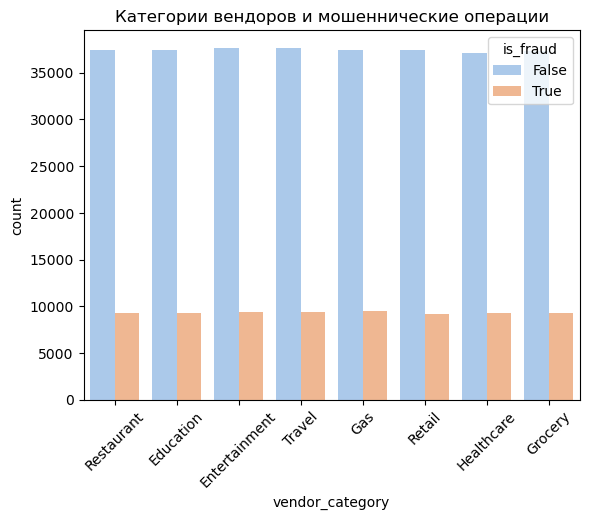

In [11]:
# Построение графиков распределения данных для категориальных переменных

sns.countplot(data=data, x='vendor_category', hue=data['is_fraud'].astype(str), palette='pastel')
plt.xticks(rotation=45)
plt.title('Категории вендоров и мошеннические операции')

Text(0.5, 1.0, 'Страны и мошеннические операции')

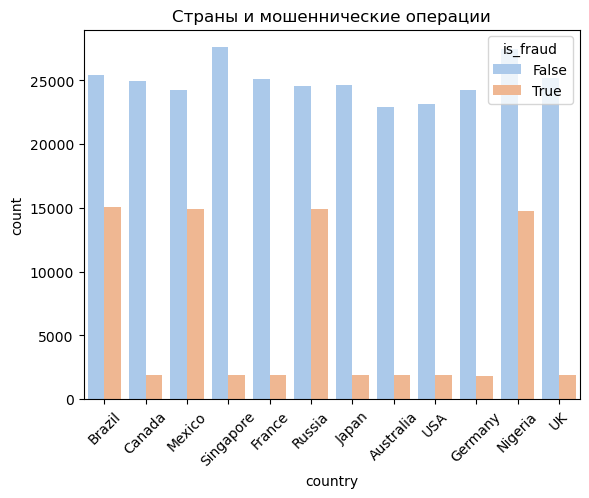

In [12]:
top_countries = data['country'].value_counts().index[:]
sns.countplot(data=data[data['country'].isin(top_countries)], x='country', hue=data['is_fraud'].astype(str), palette='pastel')
plt.xticks(rotation=45)
plt.title('Страны и мошеннические операции')

Text(0.5, 1.0, 'Каналы и мошеннические операции')

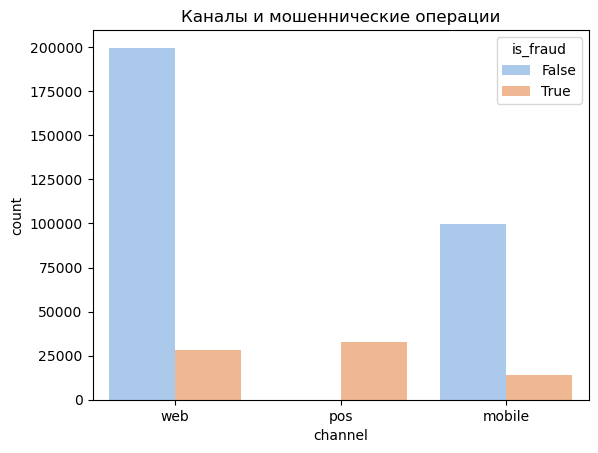

In [13]:
sns.countplot(data=data, x='channel', hue=data['is_fraud'].astype(str), palette='pastel')
plt.title('Каналы и мошеннические операции')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Basic Debit'),
  Text(1, 0, 'Basic Credit'),
  Text(2, 0, 'Platinum Credit'),
  Text(3, 0, 'Premium Debit'),
  Text(4, 0, 'Gold Credit')])

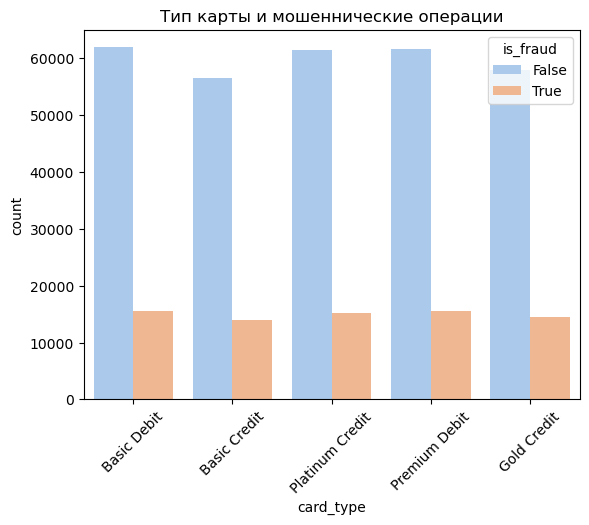

In [14]:
sns.countplot(data=data, x='card_type', hue=data['is_fraud'].astype(str), palette='pastel')
plt.title('Тип карты и мошеннические операции')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Часы транзакций и мошеннические операции')

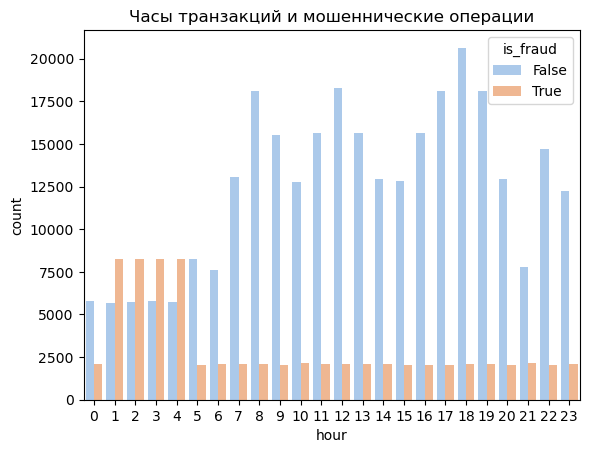

In [15]:
data['hour'] = data['timestamp'].dt.hour
sns.countplot(data=data, x='hour', hue=data['is_fraud'].astype(str), palette='pastel')
plt.title('Часы транзакций и мошеннические операции')

Text(0.5, 1.0, 'Выходные и мошеннические операции')

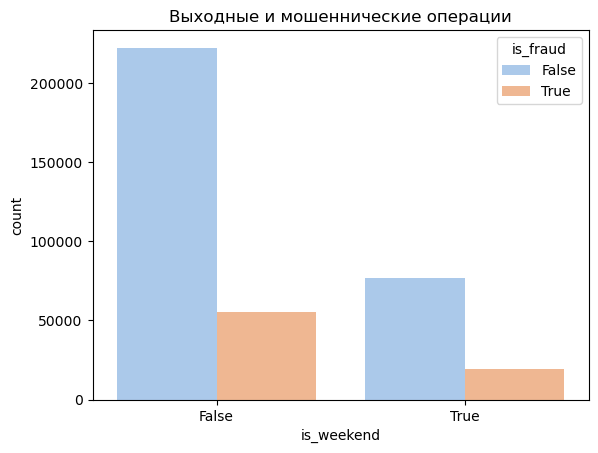

In [16]:
sns.countplot(data=data, x='is_weekend', hue=data['is_fraud'].astype(str), palette='pastel')
plt.title('Выходные и мошеннические операции')

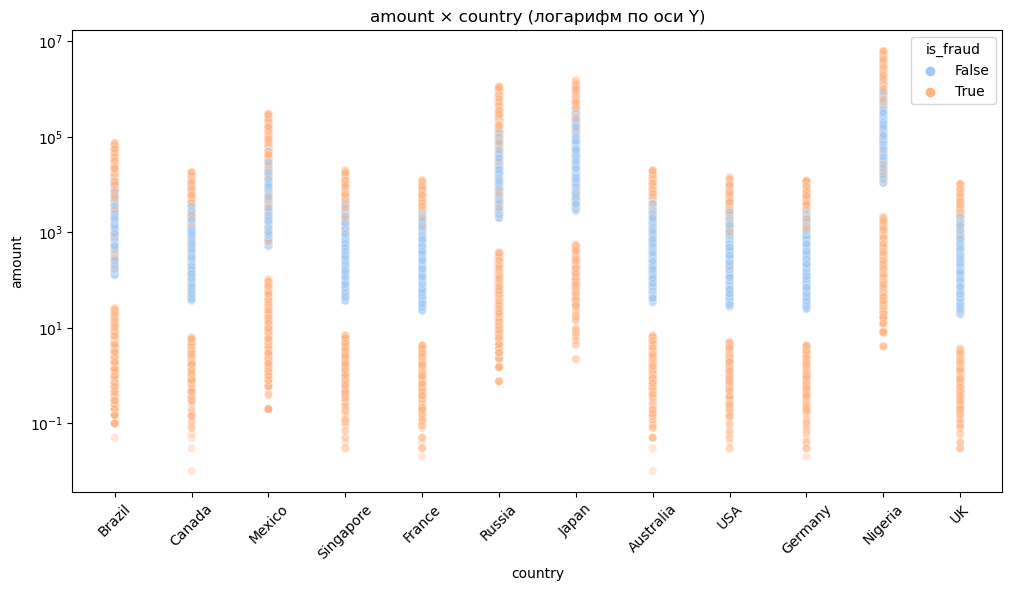

In [17]:
# Графики разброса мошениических операций по логарифму сумм и странам

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=data, x='country', y='amount', hue='is_fraud', alpha=0.3, palette='pastel',
)
plt.yscale('log')  # логарифмическая шкала для суммы (много экстремальных значений)
plt.title("amount × country (логарифм по оси Y)")
plt.xticks(rotation=45)
plt.show()

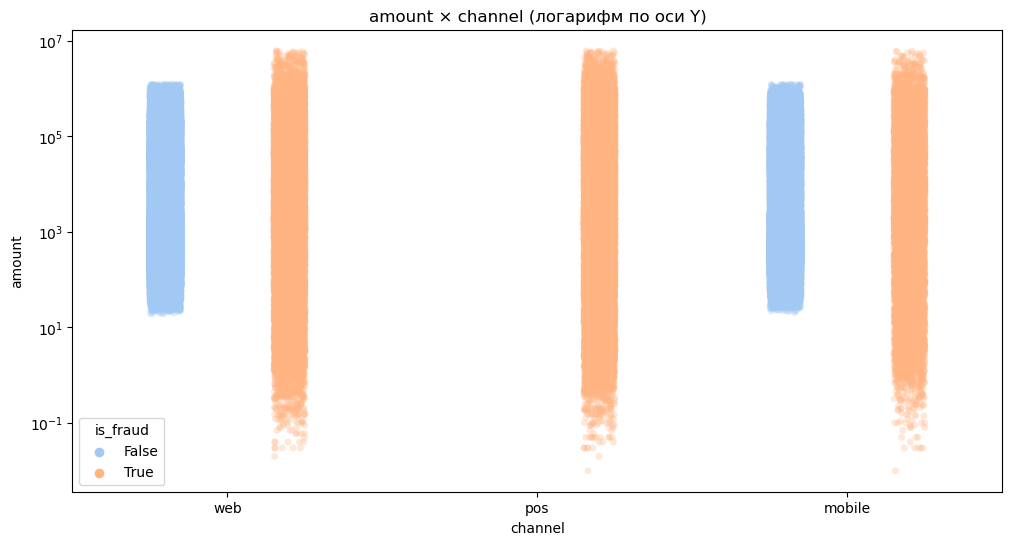

In [18]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(12,6))
sns.stripplot(
    data=data, x='channel', y='amount', hue='is_fraud', dodge=True, alpha=0.3, palette='pastel'
)
plt.yscale('log')
plt.title("amount × channel (логарифм по оси Y)")
plt.show()

C:\Users\oljago\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


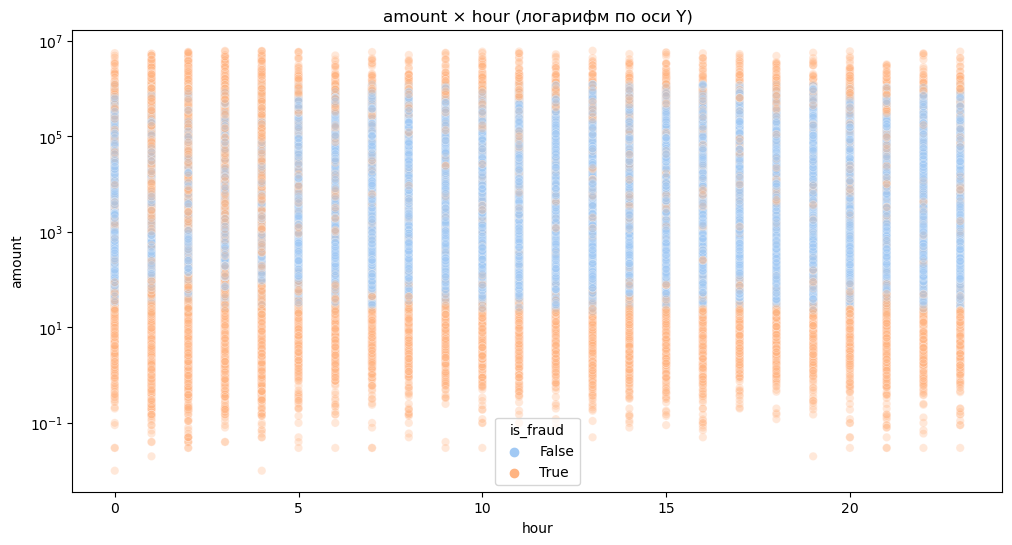

In [19]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=data, x='hour', y='amount', hue='is_fraud', alpha=0.3, palette='pastel'
)
plt.yscale('log')
plt.title("amount × hour (логарифм по оси Y)")
plt.show()

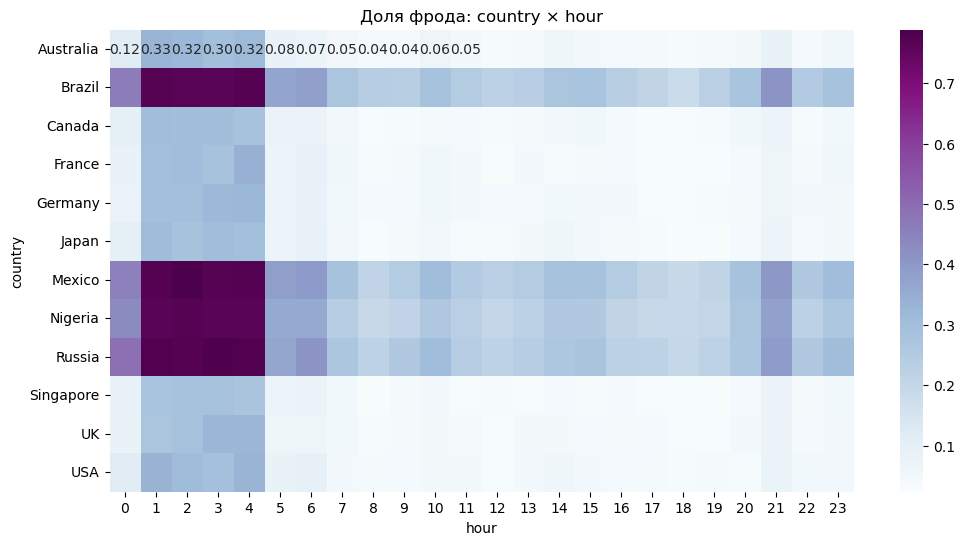

In [20]:
# Построение тепловой карты зависимости признаков
def heatmap_fraud(df, row, col):
    pivot = pd.pivot_table(
        data, 
        values='is_fraud', 
        index=row, 
        columns=col, 
        aggfunc='mean'
    )
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="BuPu")
    plt.title(f"Доля фрода: {row} × {col}")
    plt.show()

heatmap_fraud(data, 'country', 'hour')

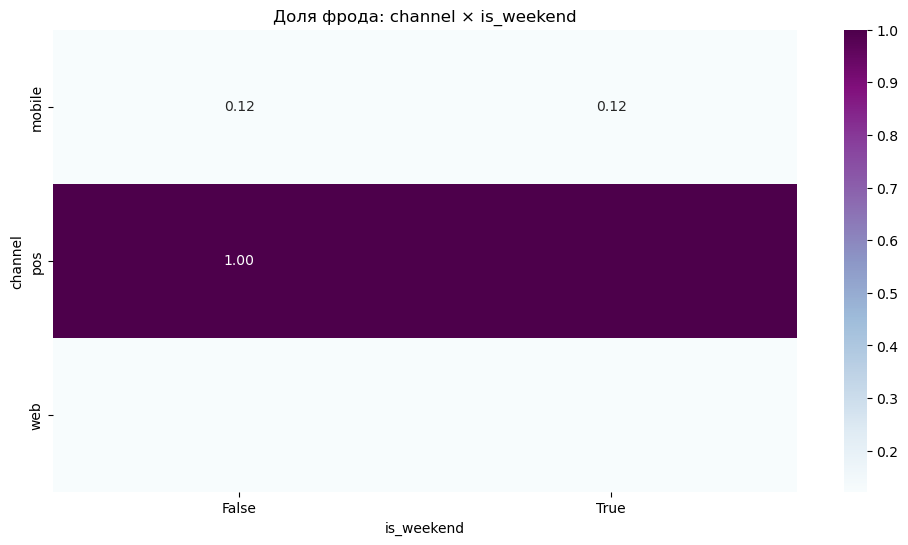

In [21]:
heatmap_fraud(data, 'channel', 'is_weekend')

In [22]:
print(data['channel'].value_counts())
print(data[data['channel'] == 'pos']['is_fraud'].value_counts(normalize=True))

channel
web       227660
mobile    113919
pos        32609
Name: count, dtype: int64
is_fraud
True    1.0
Name: proportion, dtype: float64


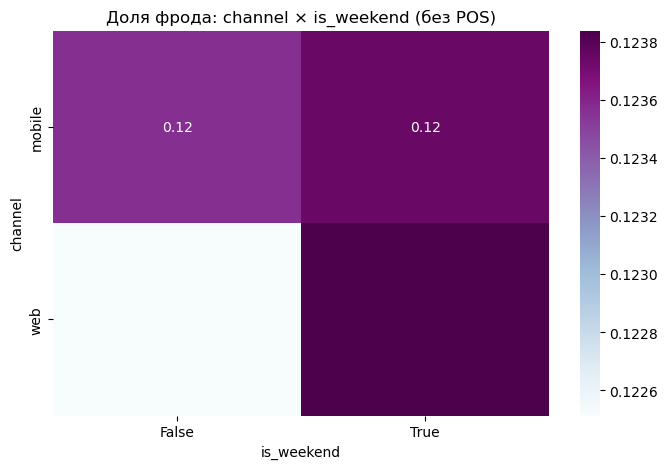

In [23]:
# отфильтровываем POS
filtered = data[data['channel'] != 'pos']

# строим сводную таблицу: доля фрода по каналам и выходным
pivot = pd.pivot_table(
    filtered,
    values='is_fraud',
    index='channel',
    columns='is_weekend',
    aggfunc='mean'
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="BuPu", cbar=True)
plt.title("Доля фрода: channel × is_weekend (без POS)")
plt.show()

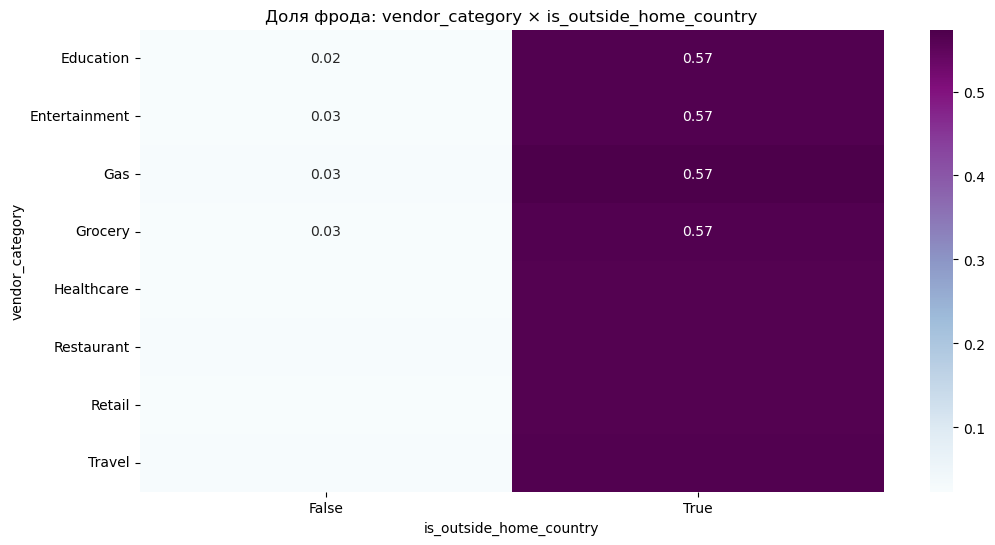

In [24]:
heatmap_fraud(data, 'vendor_category', 'is_outside_home_country')

In [25]:
# 1. Доля фрода по is_high_risk_vendor
print("Доля фрода по is_high_risk_vendor:")
print(data.groupby('is_high_risk_vendor')['is_fraud'].mean())

# 2. Доля фрода по is_card_present
print("\nДоля фрода по is_card_present:")
print(data.groupby('is_card_present')['is_fraud'].mean())

Доля фрода по is_high_risk_vendor:
is_high_risk_vendor
False    0.199306
True     0.200176
Name: is_fraud, dtype: float64

Доля фрода по is_card_present:
is_card_present
False    0.123108
True     1.000000
Name: is_fraud, dtype: float64


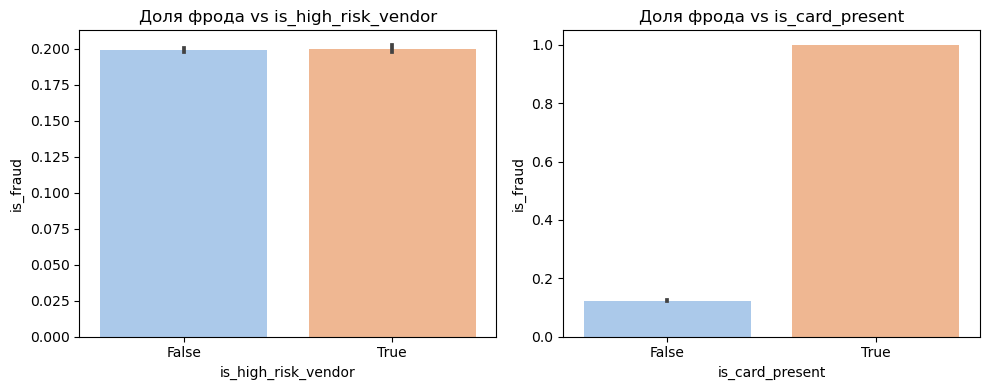

In [26]:
plt.figure(figsize=(10,4))

# is_high_risk_vendor
plt.subplot(1,2,1)
sns.barplot(data=data, x='is_high_risk_vendor', y='is_fraud', palette='pastel')
plt.title('Доля фрода vs is_high_risk_vendor')

# is_card_present
plt.subplot(1,2,2)
sns.barplot(data=data, x='is_card_present', y='is_fraud', palette='pastel')
plt.title('Доля фрода vs is_card_present')

plt.tight_layout()
plt.show()

In [27]:
pd.crosstab(data['is_card_present'], data['channel'])

channel,mobile,pos,web
is_card_present,,,
False,113919,0,227660
True,0,32609,0


# 2. Исследование зависимостей и формирование гипотез

**Выводы на основе анализа зависимостей по графикам**

**1.   Гистограммы**

Построены гистограммы и boxplot для числовых признаков:

**amount (сумма транзакции)**,

**признаки активности за последний час lha_ (кол-во транзакций, сумма, кол-во уникальных мерчантов и др.)**

Основные наблюдения:

**Amount:**

Транзакции с очень маленькими суммами (<10) и очень большими (>10,000) имеют значительно более высокую долю фрода.

Транзакции со средними суммами (100–1000) в основном честные.

**Признаки активности lha_*:**

Различий между фродом и не-фродом почти нет → малополезны поодиночке, возможно полезны только в комбинациях.

**2.   Категориальные признаки**

Проанализированы категориальные признаки: vendor_category, country, channel, card_type, is_weekend, is_high_risk_vendor, is_card_present.

Основные наблюдения:

**vendor_category:**

Заметной зависимости нет — доля фрода примерно одинакова во всех категориях.

**country:**

Бразилия, Нигерия, Россия и Мексика имеют более высокую долю фрода.

**channel:**

Канал POS имеет 100% фрода в выборке (аномалия, см. ниже).

Web и mobile примерно равны по доле фрода, но web чуть выше в выходные.

**card_type:**

Незначительно выше доля фрода у карт типа Basic Credit.

**is_weekend:**

В выходные доля фрода выше, чем в будни.

**is_high_risk_vendor:**

Почти не отличается от False → признак слабый в наших данных.

**is_card_present:**

Полностью совпадает с POS-каналом, не несёт новой информации (см. ниже).

**Аномалии:**

Все POS-транзакции = 100% фрод. Это может быть особенность данных (собрана подвыборка только из фрода по POS) или ошибка в источнике.

Признак is_card_present полностью повторяет POS и исключён из анализа.


**3.   Графики разброса**

Построены scatter-графики для проверки зависимостей:

amount vs country,

amount vs hour,

amount vs channel.

Основные наблюдения:

У крупных сумм (>10,000) фрод чаще встречается ночью.

В странах с высокой долей фрода (Бразилия, Нигерия, Россия, Мексика) риск растёт в ночные часы.


**4.   Тепловые карты (сочетанные зависимости)**


Построены тепловые карты доли фрода для пар признаков:

**country × hour:**

В Бразилии, Нигерии, России и Мексике ночью (0–5 часов) доля фрода достигает 70–80%.

**channel × is_weekend (без POS):**

Web в выходные имеет более высокий риск фрода.

Mobile стабилен в будни и выходные.

**vendor_category × is_outside_home_country:**

Любая транзакция за пределами страны клиента имеет ~57% фрода, независимо от категории.


**Гипотезы и рекомендации по результатам анализа**

**1. Сумма транзакции (amount)**
Транзакции с очень маленькими суммами (<10) и очень большими суммами (>10,000) имеют значительно более высокую долю фрода.

**Гипотеза:** такие операции стоит отправлять на усиленную проверку или блокировать до подтверждения клиента.

**2. География (country) и время (hour)**
В странах Бразилия, Нигерия, Россия и Мексика доля фрода существенно выше среднего.

В этих странах ночью (0–5 часов) доля фрода достигает 70–80%.

**Гипотеза:** ночные транзакции в странах с высоким риском требуют дополнительной проверки.

**3. Канал проведения (channel) и выходные (is_weekend)**
POS-канал в выборке полностью состоит из фрода (100%) — это особенность данных и требует отдельного анализа.

Web-канал в выходные имеет более высокий риск фрода по сравнению с буднями.

**Гипотеза:** веб-транзакции в выходные дни требуют более жёстких правил проверки.

**4. Транзакции за границей (is_outside_home_country)**
Любая транзакция за пределами страны клиента имеет ~57% вероятность фрода, независимо от категории вендора.

**Гипотеза:** транзакции за границей должны проверяться по усиленным правилам (двухфакторка, звонок клиенту и др.).

**5. Категории вендоров (vendor_category)**
Категория вендора сама по себе мало информативна, однако в сочетании с признаком is_outside_home_country резко увеличивает риск.

**Гипотеза:** использовать категорию вендора как дополнительный фактор в комбинации с другими признаками.

**6. Признаки is_card_present и is_high_risk_vendor**
is_card_present полностью совпадает с каналом POS - в нашей выборке не несёт дополнительной информации.

**is_high_risk_vendor** почти не отличается от False - слабый признак, полезен только в комбинации.

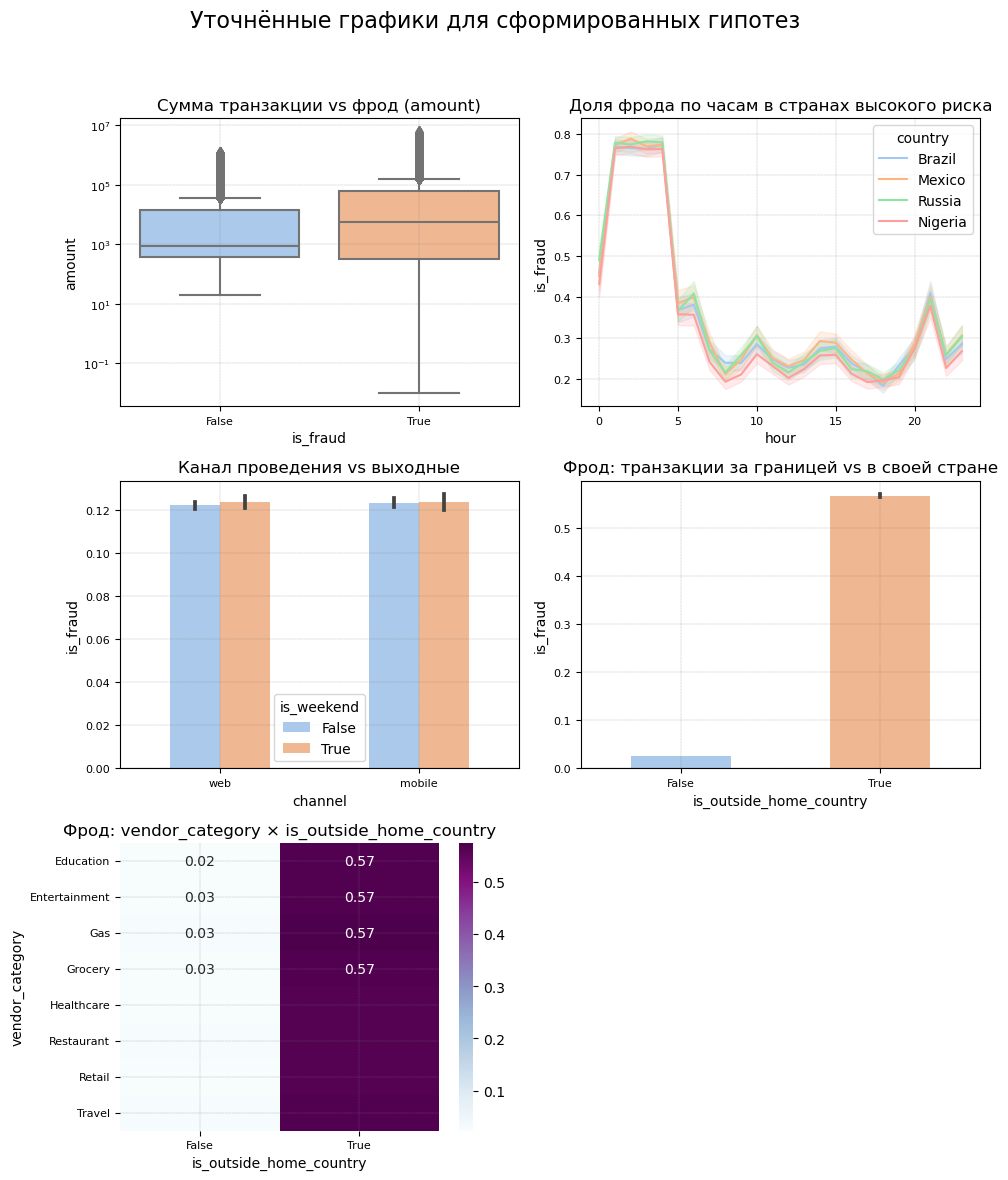

In [28]:
# Построение уточненных графиков по выдвинутым гипотезам
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('Уточнённые графики для сформированных гипотез', fontsize=16)

# 1. Сумма транзакции (amount)
sns.boxplot(data=data, x='is_fraud', y='amount', ax=axes[0,0], palette="pastel")
axes[0,0].set_yscale('log')
axes[0,0].set_title('Сумма транзакции vs фрод (amount)')

# 2. География (country) и время (hour)
risk_countries = ['Brazil', 'Nigeria', 'Russia', 'Mexico']
subset = data[data['country'].isin(risk_countries)]
sns.lineplot(data=subset, x='hour', y='is_fraud', hue='country', estimator='mean', ax=axes[0,1], palette="pastel")
axes[0,1].set_title('Доля фрода по часам в странах высокого риска')

# 3. Канал проведения (channel) и выходные (is_weekend)
filtered = data[data['channel'] != 'pos']
sns.barplot(data=filtered, x='channel', y='is_fraud', hue=filtered['is_weekend'].astype(str), estimator='mean', ax=axes[1,0], palette="pastel",
    width=0.5)
axes[1,0].set_title('Канал проведения vs выходные')

# 4. Транзакции за границей (is_outside_home_country)
sns.barplot(data=data, x='is_outside_home_country', y='is_fraud', ax=axes[1,1], palette="pastel", width=0.5)
axes[1,1].set_title('Фрод: транзакции за границей vs в своей стране')

# 5. Категории вендоров (vendor_category × is_outside_home_country)
top_categories = data['vendor_category'].value_counts().head(8).index
subset = data[data['vendor_category'].isin(top_categories)]
pivot = pd.pivot_table(subset, values='is_fraud', index='vendor_category', columns='is_outside_home_country', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="BuPu", ax=axes[2,0])
axes[2,0].set_title('Фрод: vendor_category × is_outside_home_country')

axes[2,1].axis('off')

for ax in axes.flat:
    if ax.has_data():
        ax.grid(True, linewidth=0.2, linestyle='--', color='gray')
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


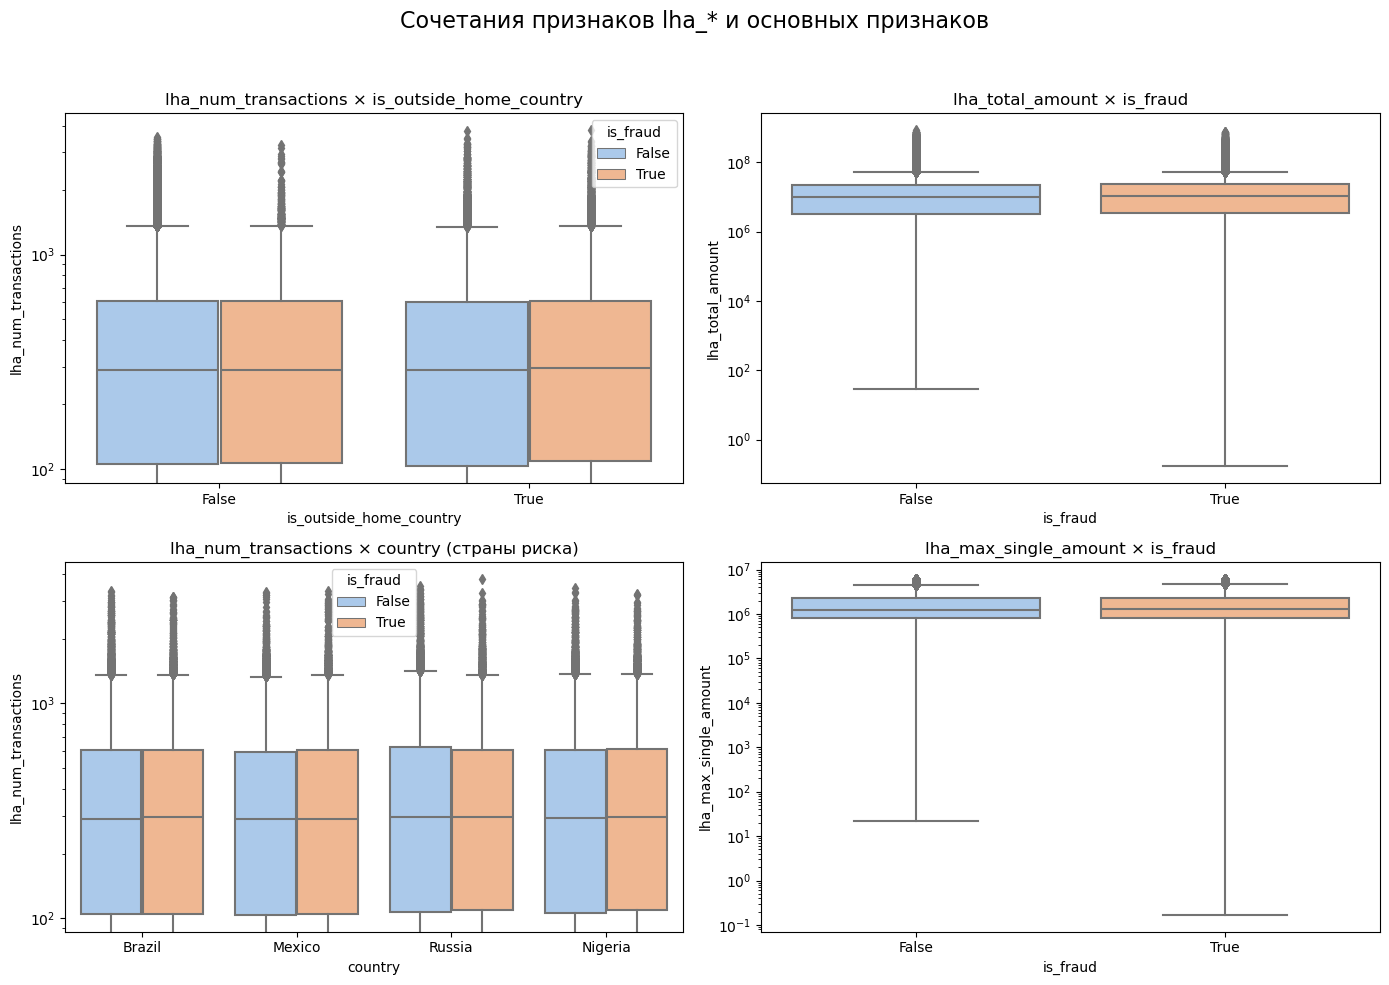

In [29]:
# Построение сочетанных графиков основных признаков и последней активности за час
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Сочетания признаков lha_* и основных признаков', fontsize=16)

# 1. Количество транзакций за час vs фрод (и за границей/своей стране)
sns.boxplot(
    data=data,
    x='is_outside_home_country',
    y='lha_num_transactions',
    hue='is_fraud',
    ax=axes[0,0],
    palette="pastel"
)
axes[0,0].set_yscale('log')
axes[0,0].set_title('lha_num_transactions × is_outside_home_country')

# 2. Общая сумма транзакций за час vs фрод
sns.boxplot(
    data=data,
    x='is_fraud',
    y='lha_total_amount',
    ax=axes[0,1],
    palette="pastel"
)
axes[0,1].set_yscale('log')
axes[0,1].set_title('lha_total_amount × is_fraud')

# 3. Количество транзакций за час в странах высокого риска
risk_countries = ['Brazil', 'Nigeria', 'Russia', 'Mexico']
subset = data[data['country'].isin(risk_countries)]
sns.boxplot(
    data=subset,
    x='country',
    y='lha_num_transactions',
    hue='is_fraud',
    ax=axes[1,0],
    palette="pastel"
)
axes[1,0].set_yscale('log')
axes[1,0].set_title('lha_num_transactions × country (страны риска)')

# 4-я ячейка пустая или можно добавить lha_max_single_amount × is_fraud
sns.boxplot(
    data=data,
    x='is_fraud',
    y='lha_max_single_amount',
    ax=axes[1,1],
    palette="pastel"
)
axes[1,1].set_yscale('log')
axes[1,1].set_title('lha_max_single_amount × is_fraud')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


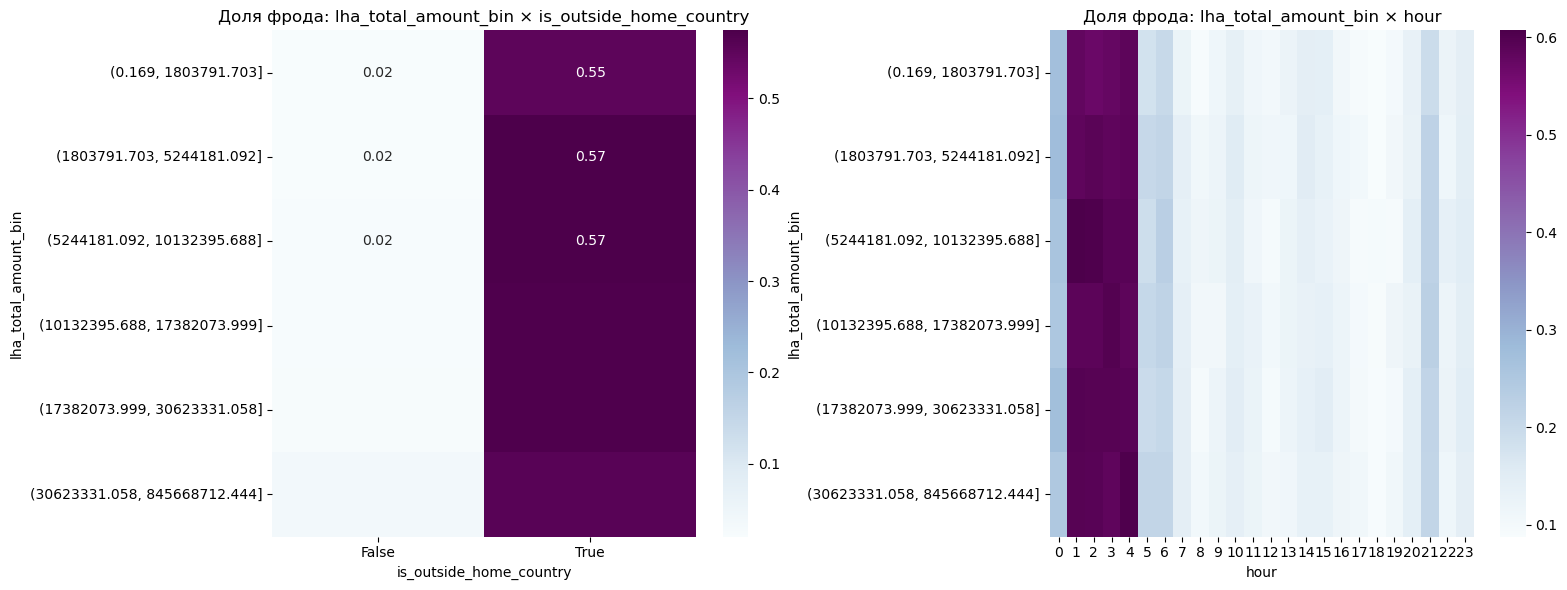

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Создадим бины для lha_total_amount
data['lha_total_amount_bin'] = pd.qcut(data['lha_total_amount'], q=6, duplicates='drop')

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# 1. lha_total_amount_bin × is_outside_home_country
pivot1 = pd.pivot_table(
    data, values='is_fraud', index='lha_total_amount_bin',
    columns='is_outside_home_country', aggfunc='mean'
)
sns.heatmap(pivot1, annot=True, cmap="BuPu", fmt=".2f", ax=axes[0])
axes[0].set_title('Доля фрода: lha_total_amount_bin × is_outside_home_country')

# 2. lha_total_amount_bin × hour
pivot2 = pd.pivot_table(
    data, values='is_fraud', index='lha_total_amount_bin',
    columns='hour', aggfunc='mean'
)
sns.heatmap(pivot2, annot=False, cmap="BuPu", ax=axes[1])
axes[1].set_title('Доля фрода: lha_total_amount_bin × hour')

plt.tight_layout()
plt.show()


In [31]:
from IPython.display import display

# Сводные таблицы зависимости оттока и основных категориальных признаков
columns = ['country', 'channel', 'vendor_category', 'card_type',
           'is_outside_home_country', 'is_weekend']

for col in columns:
    display(data.pivot_table(values='is_fraud', index=col))
    print('\n')

,is_fraud
country,
Australia,0.075585
Brazil,0.372218
Canada,0.069474
France,0.069975
Germany,0.070980
Japan,0.070245
Mexico,0.380779
Nigeria,0.350207
Russia,0.377634


,is_fraud
channel,
mobile,0.123614
pos,1.000000
web,0.122854


,is_fraud
vendor_category,
Education,0.198662
Entertainment,0.199979
Gas,0.202654
Grocery,0.199241
Healthcare,0.199517
Restaurant,0.199551
Retail,0.196191
Travel,0.200374


,is_fraud
card_type,
Basic Credit,0.197989
Basic Debit,0.200003
Gold Credit,0.200679
Platinum Credit,0.197951
Premium Debit,0.200931


,is_fraud
is_outside_home_country,
False,0.025172
True,0.566641


,is_fraud
is_weekend,
False,0.199376
True,0.199956


# 3. Итоговые выводы по исследованию данных

### **Цель исследования:**
Целью работы был анализ транзакций и выявление ключевых факторов, влияющих на вероятность мошенничества. 

Мы провели полный EDA: изучили числовые и категориальные признаки, проверили сочетанные зависимости, 
сформулировали гипотезы и бизнес-рекомендации.


### **Ключевые зависимости:**

1. **Сумма транзакции (amount):**
   - Экстремально маленькие (<10) и большие суммы (>10,000) связаны с повышенной долей фрода.

2. **География и время:**
   - В странах высокого риска (Бразилия, Нигерия, Россия, Мексика) ночью (0–5 часов) доля фрода достигает 70–80%.
   - В остальных странах ночью риск также выше, но не так сильно.

3. **Каналы и выходные:**
   - Web-канал в выходные подвержен большему риску фрода, чем в будни.
   - Mobile-канал относительно стабилен.
   - POS-канал содержит 100% фрода в выборке (аномалия, требует отдельного анализа).

4. **Транзакции за границей:**
   - Любая транзакция за пределами страны клиента имеет ~57% вероятность фрода, независимо от категории вендора или суммы.

5. **Категории вендоров:**
   - Сами по себе малоинформативны, но в сочетании с признаками "за границей" или "ночью" риск фрода резко возрастает.

6. **Признаки активности за последний час (lha_):**
   - Сами по себе слабые, но фрод чаще сопровождается множеством очень мелких транзакций за короткое время 
     (низкие значения `lha_total_amount` и `lha_max_single_amount`).

### **Аномалии и слабые признаки**
- POS-канал: 100% транзакций фрод → исключён из анализа или требует отдельного рассмотрения.
- Признак `is_card_present` полностью дублирует POS и не несёт новой информации.
- Признак `is_high_risk_vendor` и `vendor_category` по отдельности слабые, полезны только в сочетаниях.


---

### **Бизнес-рекомендации**

1. **Усилить проверку транзакций:**
   - С экстремально малыми и большими суммами.
   - В странах высокого риска ночью.
   - Веб-транзакций в выходные.

2. **Отдельный контроль:**
   - Всех транзакций за границей → двухфакторная аутентификация или звонок клиенту.
   - POS-канала (уточнить данные или вводить повышенные проверки).

3. **Использовать комбинации признаков:**
   - Country + hour.
   - Channel + is_weekend.
   - Vendor_category + is_outside_home_country.
   - lha_total_amount/lha_max_single_amount в сочетании с географией и временем.
